In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from afinn import Afinn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from collections import Counter
import nltk.data

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [2]:
# read the dataset
reviews_data = pd.read_json(r"C:\Users\user\Documents\UoM\Thesis\data\Clothing_Shoes_and_Jewelry_5.json", lines=True)

# Keep only the review text and the grade
reviews_data = reviews_data[['overall', 'reviewText']]


# Drop the products whose values are null
reviews_data = reviews_data[reviews_data['reviewText'].notna()]

In [3]:
ratings = []
for index,entry in enumerate(reviews_data['overall']):
    if entry == 1.0 or entry == 2.0:
        ratings.append(-1)
    elif entry == 3.0:
        ratings.append(0)
    elif entry == 4.0 or entry == 5.0:
        ratings.append(1)

In [4]:
""""
Split each review into sentences
and preprocess each sentence
"""

preprocessed_data = []
index = 0
for review in reviews_data['reviewText']:
    if(index % 10000 == 0):
        print(str(round(((index/len(reviews_data)*100)), 2)) + "% of the total reviews have been preprocessed")  
    review_sentences = tokenizer.tokenize(review)
    for sentence in review_sentences:
        if(sentence != ''):
            review = {}
            review["index"] = index
            review["sentence"] = sentence
            review["rating"] = ratings[index]
            preprocessed_data.append(review)
    index += 1
print("100% of the total reviews have been preprocessed")

0.0% of the total reviews have been preprocessed
3.59% of the total reviews have been preprocessed
7.18% of the total reviews have been preprocessed
10.77% of the total reviews have been preprocessed
14.35% of the total reviews have been preprocessed
17.94% of the total reviews have been preprocessed
21.53% of the total reviews have been preprocessed
25.12% of the total reviews have been preprocessed
28.71% of the total reviews have been preprocessed
32.3% of the total reviews have been preprocessed
35.88% of the total reviews have been preprocessed
39.47% of the total reviews have been preprocessed
43.06% of the total reviews have been preprocessed
46.65% of the total reviews have been preprocessed
50.24% of the total reviews have been preprocessed
53.83% of the total reviews have been preprocessed
57.41% of the total reviews have been preprocessed
61.0% of the total reviews have been preprocessed
64.59% of the total reviews have been preprocessed
68.18% of the total reviews have been

In [5]:
print("Before preprocessing: ", reviews_data['reviewText'][278643])
print("------------------------------------------------")
print("After preprocessing: ", [d for d in preprocessed_data if d['index'] == 278643])
print(len(preprocessed_data))

Before preprocessing:  idk why this shirt didnt fit i mean i ordered an Xlits very short and it seems like it was cut weird because the cross sits funny, like sideways.also one of the studs fell off the second i tried it on. ahhhhhhh whatever thats what i get for ordering clothes online loli DO NOT recommend
------------------------------------------------
After preprocessing:  [{'index': 278643, 'sentence': 'idk why this shirt didnt fit i mean i ordered an Xlits very short and it seems like it was cut weird because the cross sits funny, like sideways.also one of the studs fell off the second i tried it on.', 'rating': -1}, {'index': 278643, 'sentence': 'ahhhhhhh whatever thats what i get for ordering clothes online loli DO NOT recommend', 'rating': -1}]
1185548


In [6]:
df = pd.DataFrame(preprocessed_data)

In [7]:
afinn = Afinn()

def calculate_afinn_score(sentence):
    return afinn.score(sentence)

In [8]:
def get_sentiment_from_score(predicted_score):
    if predicted_score > 0:
        return 1
    elif predicted_score < 0:
        return -1
    else:
        return 0

In [9]:
# Calculate predicted scores using afinn lexicon approcach
df['predicted_score'] = df.apply(lambda x: calculate_afinn_score(x['sentence']), axis=1)

# Get the sentiment from the caluclated score
df['predicted_sentiment'] = df.apply(lambda x: get_sentiment_from_score(x['predicted_score']), axis=1)

In [10]:
def find_Max_Element(scores):
    c = Counter(scores)
    negatives = c[-1]
    neutral = c[0]
    positives = c[1]
    
    if(scores[0] == -1):
        negatives += 1
    elif(scores[0] == 0):
        neutral += 1
    elif(scores[0] == 1):
        positives += 1
    
    
    if(scores[-1] == -1):
        negatives += 1
    elif(scores[-1] == 0):
        neutral += 1
    elif(scores[-1] == 1):
        positives += 1

    if(neutral == positives and neutral > negatives and positives > negatives):
        max_element = 1
    elif (neutral == negatives and neutral > positives and negatives > positives):
        max_element = -1
    elif (neutral == negatives and negatives == positives):
        max_element = 0
    elif (positives == negatives and positives > neutral and negatives > neutral) :
        max_element = 0
    else:
        max_element = max(set(scores), key = scores.count)
        
    return max_element

Accuracy:  67.87581687618652
              precision    recall  f1-score   support

    Negative       0.37      0.15      0.21     26652
     Neutral       0.16      0.33      0.21     30423
    Positive       0.85      0.79      0.82    221578

    accuracy                           0.68    278653
   macro avg       0.46      0.42      0.42    278653
weighted avg       0.73      0.68      0.70    278653



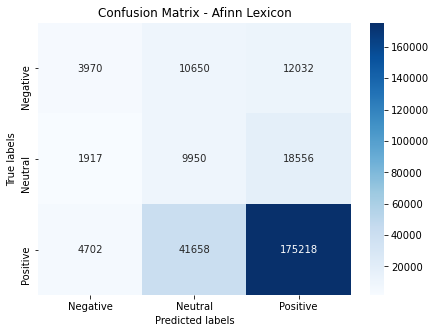

In [11]:
# Report 

# for each review get all scores by review
scores_by_review_frame = df.groupby('index')['predicted_sentiment'].apply(list)
majority_scores =  scores_by_review_frame.apply(find_Max_Element)
predicted_scores = list(majority_scores)

# for each review get its actual score
actual_scores_frame = df.groupby('index')['rating'].first()
actual_scores = list(actual_scores_frame)

# get all indexes
review_indexes = df['index'].unique()

# Calculate Accuracy
accuracy = accuracy_score(predicted_scores, actual_scores)*100
print("Accuracy: ", accuracy)

# Confusion Matrix
cm = confusion_matrix(actual_scores, predicted_scores)
plt.figure(figsize = (7,5))
ax = plt.subplot()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',ax=ax)
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - Afinn Lexicon'); 
ax.xaxis.set_ticklabels(['Negative', 'Neutral', 'Positive']); 
ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive']);

# Classification Report
my_tags = ['Negative','Neutral','Positive']
print(classification_report(actual_scores, predicted_scores, target_names=my_tags))
report = classification_report(actual_scores, predicted_scores, target_names=my_tags, output_dict=True);
clsf_report = pd.DataFrame(report).transpose()
clsf_report.to_csv('reports/Lexicon_Based_Afinn.csv', index= True)

In [12]:
# write indexes of false classified reviews to a txt file

data = {"review_index": review_indexes, "predict": predicted_scores, "actual": actual_scores}

review_dataframe = pd.DataFrame(data)

false_classified_indexes = review_dataframe['review_index'][review_dataframe['predict'] != review_dataframe['actual']]
false_classified_indexes = list(false_classified_indexes)

with open("indexes/Lexicon_Based_Afinn.txt", 'w') as f:
    for item in false_classified_indexes:
        f.write("%s\n" % item)
        
        # save those indexes who are predicted as negative but they are neutral
negativePredicted_neutralActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] == -1) & (review_dataframe['actual'] == 0)]
negativePredicted_neutralActual_indexes = list(negativePredicted_neutralActual_indexes)
with open("indexes/Lexicon_Based_Afinn_NegativePredicted_NeutralActual.txt", 'w') as f:
    for item in negativePredicted_neutralActual_indexes:
        f.write("%s\n" % item)

# save those indexes who are predicted as negative but they are positive
negativePredicted_positiveActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] == -1) & (review_dataframe['actual'] == 1)]
negativePredicted_positiveActual_indexes = list(negativePredicted_positiveActual_indexes)
with open("indexes/Lexicon_Based_Afinn_NegativePredicted_PositiveActual.txt", 'w') as f:
    for item in negativePredicted_positiveActual_indexes:
        f.write("%s\n" % item)
        
# save those indexes who are predicted as neutral but they are negative
neutralPredicted_negativeActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] ==0) & (review_dataframe['actual'] == -1)]
neutralPredicted_negativeActual_indexes = list(neutralPredicted_negativeActual_indexes)
with open("indexes/Lexicon_Based_Afinn_NeutralPredicted_NegativeActual.txt", 'w') as f:
    for item in neutralPredicted_negativeActual_indexes:
        f.write("%s\n" % item)

# save those indexes who are predicted as neutral but they are positive
neutralPredicted_positiveActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] ==0) & (review_dataframe['actual'] == 1)]
neutralPredicted_positiveActual_indexes = list(neutralPredicted_positiveActual_indexes)
with open("indexes/Lexicon_Based_Afinn_NeutralPredicted_PositiveActual.txt", 'w') as f:
    for item in neutralPredicted_positiveActual_indexes:
        f.write("%s\n" % item)

# save those indexes who are predicted as positive but they are negative        
positivePredicted_negativeActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] ==1) & (review_dataframe['actual'] == -1)]
positivePredicted_negativeActual_indexes = list(positivePredicted_negativeActual_indexes)
with open("indexes/Lexicon_Based_Afinn_PositivePredicted_NegativeActual.txt", 'w') as f:
    for item in positivePredicted_negativeActual_indexes:
        f.write("%s\n" % item)
 
# save those indexes who are predicted as positive but they are neutral 
positivePredicted_neutralActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] ==1) & (review_dataframe['actual'] == 0)]
positivePredicted_neutralActual_indexes = list(positivePredicted_neutralActual_indexes)
with open("indexes/Lexicon_Based_Afinn_PositivePredicted_NeutralActual.txt", 'w') as f:
    for item in positivePredicted_neutralActual_indexes:
        f.write("%s\n" % item)